In [291]:
import numpy as np
import pandas as pd
import time
import torch
import torch.utils.data as Data
from utils import *
from MF import *
from models import *
from torch_dataset import *
from sklearn.model_selection import KFold
import random
import argparse
from data_process import data_process
import os

In [292]:
def PairFeatures(pairs, drug_subfeat, cline_subfeat, drug_glofeat, cline_glofeat, drug_compo_elem):
    drug_subs = []; cline_subs = [] 
    drug_glos = []; cline_glos = [] 
    drug_compos = []; cline_compos = []
    label = []
    for _, row in pairs.iterrows():   
        cline_subs.append(cline_subfeat[str(row[0])])
        drug_subs.append(drug_subfeat[str(row[1])])
        cline_glos.append(np.array(cline_glofeat.loc[row[0]]))
        drug_glos.append(np.array(drug_glofeat.loc[row[1]]))
        drug_compos.append([row[1], drug_compo_elem[str(row[1])]])
        cline_compos.append([row[0], cline_compos_elem])
        label.append(row[2])    
    return drug_subs, cline_subs, drug_glos, cline_glos, drug_compos, cline_compos, label
def BatchGenerate(pairs, drug_subfeat, cline_subfeat, drug_glofeat, cline_glofeat, drug_compo_elem, bs):    
    drug_subs, cline_subs, drug_glos, cline_glos, drug_compos, cline_compos, label\
               = PairFeatures(pairs, drug_subfeat, cline_subfeat, drug_glofeat, cline_glofeat, drug_compo_elem)
    ds_loader = Data.DataLoader(BatchData(drug_subs), batch_size=bs, shuffle=False, collate_fn=collate_seq)
    cs_loader = Data.DataLoader(BatchData(cline_subs), batch_size=bs, shuffle=False)
    glo_loader = Data.DataLoader(PairsData(drug_glos, cline_glos), batch_size=bs, shuffle=False)
    label = torch.from_numpy(np.array(label, dtype='float32')).to(device)
    label = Data.DataLoader(dataset = Data.TensorDataset(label), batch_size=bs, shuffle=False)
    return ds_loader, cs_loader, glo_loader, drug_compos, cline_compos, label

def getBinary(Tensors, thresh=-2):
    ones = torch.ones_like(Tensors)
    zeros = torch.zeros_like(Tensors)
    return torch.where(Tensors < thresh, ones, zeros)

In [293]:
seed = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
drug_subfeat, cline_subfeat, CDR_pairs, drug_dim, drug_compo_elem, cline_compos_elem = data_process()
train_size = 0.9
CV, Independent = np.split(CDR_pairs.sample(frac = 1, random_state = seed), [int(train_size * len(CDR_pairs))])
CDR_known = CV.set_index(['Cline', 'Drug']).unstack('Cline')
CDR_known.columns = CDR_known.columns.droplevel()
#---MF    
CDR_matrix = np.array(CDR_known)
CDR_mask = 1-np.float32(np.isnan(CDR_matrix))
CDR_matrix[np.isnan(CDR_matrix)] = 0
drug_glofeat, cline_glofeat = svt_solve(A = CDR_matrix, mask = CDR_mask)
drug_glofeat = pd.DataFrame(drug_glofeat); cline_glofeat = pd.DataFrame(cline_glofeat)
drug_glofeat.index = list(CDR_known.index); cline_glofeat.index = list(CDR_known.columns)    
glo_dim = 2*drug_glofeat.shape[1]
Result = []
#Randomly shuffle samples
CV = CV.sample(frac = 1, random_state = seed)
Independent = Independent.sample(frac = 1, random_state = seed)
batch_sizes = 1
drug_loader_train, cline_loader_train, glo_loader_train, _, _, label_train = BatchGenerate(CV, \
                   drug_subfeat, cline_subfeat, drug_glofeat, cline_glofeat, drug_compo_elem, bs = batch_sizes)
drug_loader_test, cline_loader_test, glo_loader_test, dc_test, cc_test, label_test = BatchGenerate(Independent, \
                   drug_subfeat, cline_subfeat, drug_glofeat, cline_glofeat, drug_compo_elem, bs = batch_sizes)
response = pd.read_csv('data/GDSC2_fitted_dose_response_25Feb20.csv', index_col = 0)

Total 117665 CDR pairs across 800 cell lines and 175 drugs.


In [ ]:
model = SubCDR(SubEncoder(in_drug = drug_dim, in_cline = 8, out = 82), GraphEncoder(in_channels = 32, out_channels = 16), \
               GloEncoder(in_channels = glo_dim, out_channels = 128), Decoder(in_channels = 160)).to(device)   
model.load_state_dict(torch.load('output_dir/classification_model.pkl'))

<All keys matched successfully>

Cancer cell line:  KYSE-520
Drug:  AZD5991
tensor([[0.3181, 0.3888],
        [0.6101, 0.6009],
        [0.2621, 0.4826],
        [0.3891, 0.4954],
        [0.5709, 0.6127],
        [0.4629, 0.5163],
        [0.4777, 0.4487],
        [0.2608, 0.3769]], device='cuda:0')


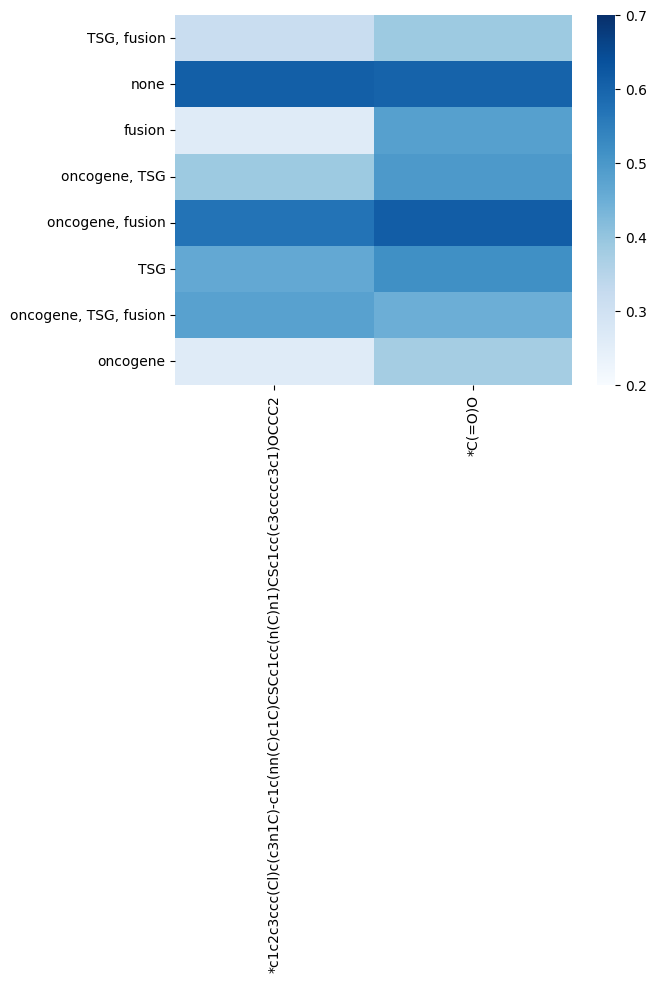

*C(=O)O
Cancer cell line:  Mewo
Drug:  AZD3759
tensor([[0.5441, 0.6216, 0.6457, 0.6956, 0.6350, 0.6756, 0.6883],
        [0.4918, 0.5068, 0.5024, 0.4560, 0.5027, 0.4762, 0.4885],
        [0.4885, 0.4728, 0.5333, 0.5900, 0.5831, 0.6284, 0.5798],
        [0.4583, 0.4685, 0.4890, 0.4685, 0.4791, 0.4956, 0.4900],
        [0.5425, 0.5259, 0.5547, 0.5578, 0.5880, 0.5320, 0.5330],
        [0.4852, 0.5008, 0.5151, 0.4957, 0.5013, 0.4527, 0.4784],
        [0.4628, 0.4501, 0.4585, 0.4274, 0.4412, 0.4174, 0.4236],
        [0.5987, 0.6204, 0.6303, 0.7391, 0.6962, 0.7262, 0.6904]],
       device='cuda:0')


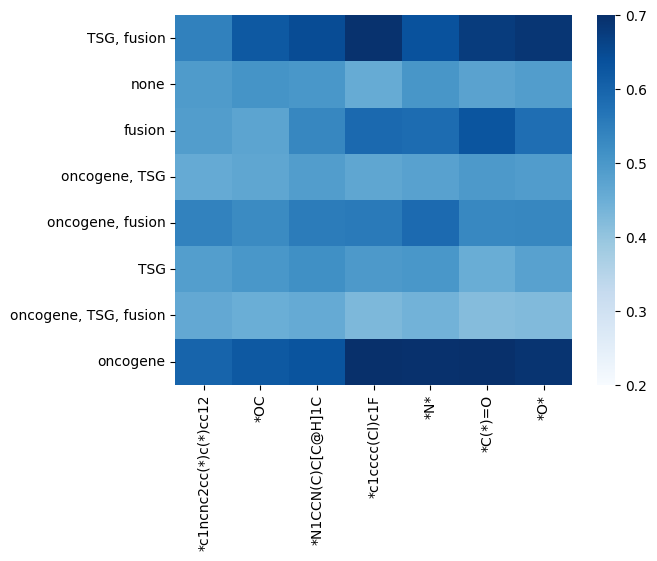

*c1cccc(Cl)c1F


In [ ]:
#test for one data using model
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()
i=0
drug_smiles = pd.read_csv('data/drug_smiles.csv', index_col=0)
cline_id = pd.read_csv('data/masked_cancer_gene/Cline_to_TumourType.csv',index_col=0)
cline_id
with torch.no_grad():
    for batch, (drug, cline, glo_feat, label, dc, cc) in enumerate(zip(drug_loader_test,\
                                                 cline_loader_test, glo_loader_test, label_test, dc_test, cc_test)):
        c_id = Independent.iloc[batch]['Cline']
        c_name = cline_id.loc[c_id]['CELL_LINE_NAME']
        d_id = Independent.iloc[batch]['Drug']
        d_smiles = drug_smiles.loc[d_id]['Isosmiles']
        label = getBinary(label[0])
        pred, maps = model(drug.to(device), cline.to(device), glo_feat.to(device))
        print('Cancer cell line: ', c_name)
        print('Drug: ', d_id)
        sns.heatmap(maps[0].T.cpu().numpy(),xticklabels=dc[1], yticklabels=cc[1], cmap='Blues', vmin=0.2, vmax=0.7)
        plt.show()
        max_indices = torch.argmax(maps[0].T)
        col, row = divmod(max_indices.item(), maps[0].T.shape[-1])
        print(dc_test[batch][1][row])
        draw_mol(d_id+"_"+c_name, d_smiles, dc_test[batch][1][row])
        i+=1
        if(i==2):
            break

In [ ]:
def draw_mol(mol_name, mol_smiles, sub_smiles):
    from rdkit import Chem
    from rdkit.Chem import AllChem,Draw
    from rdkit.Chem.Draw import rdMolDraw2D
    from IPython.display import SVG
    from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
    mol = Chem.MolFromSmiles(mol_smiles)
    patt = Chem.MolFromSmarts(sub_smiles)
    hit_ats = mol.GetSubstructMatches(patt)
    bond_lists = []
    for i, hit_at in enumerate(hit_ats):
        hit_at = list(hit_at)
        bond_list = []
        for bond in patt.GetBonds():
            a1 = hit_at[bond.GetBeginAtomIdx()]
            a2 = hit_at[bond.GetEndAtomIdx()]
            bond_list.append(mol.GetBondBetweenAtoms(a1, a2).GetIdx())
        bond_lists.append(bond_list)
    colours = [(0, 1, 0), (0, 1, 0), (0, 1, 0)]
    atom_cols = {}
    bond_cols = {}
    atom_list = []
    bond_list = []
    for i, (hit_atom, hit_bond) in enumerate(zip(hit_ats, bond_lists)):
        hit_atom = list(hit_atom)
        for at in hit_atom:
            atom_cols[at] = colours[i%3]
            atom_list.append(at)
        for bd in hit_bond:
            bond_cols[bd] = colours[i%3]
            bond_list.append(bd)
    d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                        highlightAtomColors=atom_cols,
                                        highlightBonds=bond_list,
                                        highlightBondColors=bond_cols)
    d.drawOptions().bondLineWidth = 1
    d.FinishDrawing()
    res = d.GetDrawingText()
    with open(f'{mol_name}.svg', 'w') as result:
        result.write(res)